   Symbol  Annual Return  Volatility
0    AAPL       0.285346    0.316514
1    MSFT       0.239038    0.304418
2     JNJ       0.061077    0.196876
3     JPM       0.212893    0.322573
4     XOM       0.190288    0.341502
..    ...            ...         ...
95    VCR       0.180530    0.262620
96   ICLN       0.053308    0.328756
97    XBI       0.054759    0.352477
98    RSP       0.128826    0.219959
99   ACWI       0.122159    0.198732

[100 rows x 3 columns]


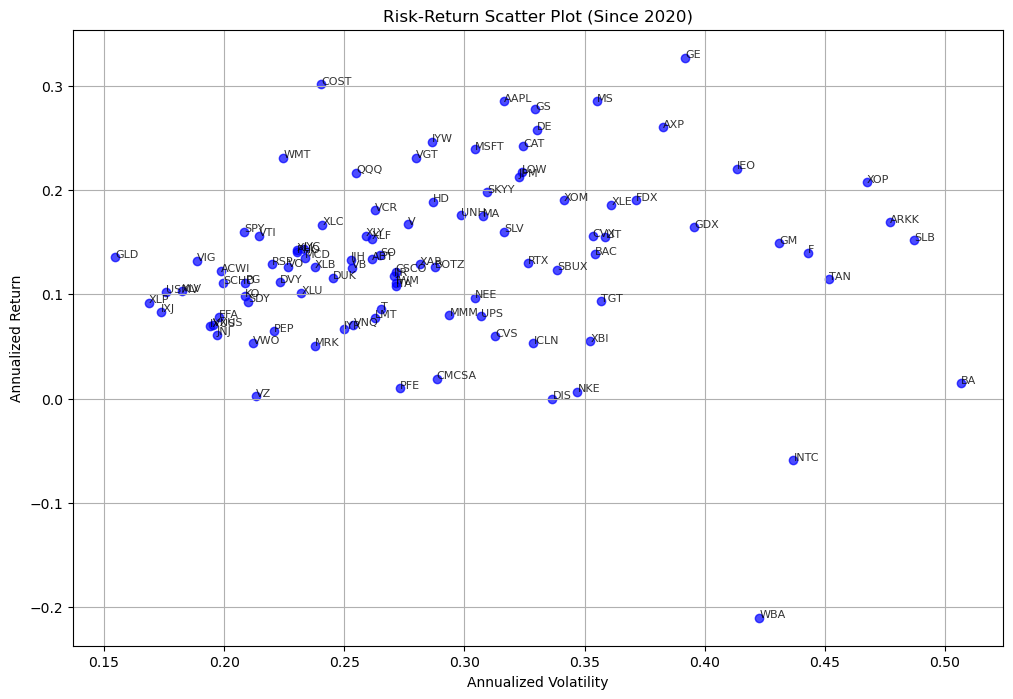

In [1]:
# Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define a diversified list of 100 tickers (50 stocks and 50 ETFs)
tickers = [
    # Stocks (50)
    "AAPL", "MSFT", "JNJ", "JPM", "XOM", "WMT", "PG", "KO", "INTC", "CSCO",
    "PFE", "MRK", "BAC", "CVX", "BA", "MMM", "GE", "MCD", "V", "MA",
    "HD", "SBUX", "NKE", "F", "GM", "LMT", "UNH", "ABT", "DIS", "T",
    "VZ", "CMCSA", "WBA", "CVS", "RTX", "CAT", "DE", "AXP", "GS", "MS",
    "TGT", "COST", "FDX", "UPS", "NEE", "DUK", "SO", "SLB", "PEP", "LOW",
    # ETFs (50)
    "SPY", "QQQ", "IWM", "VTI", "EFA", "VWO", "GLD", "SLV", "IYR", "VNQ",
    "XLE", "XLF", "XLI", "XLV", "XLY", "XLP", "XLU", "XLB", "XLC", "IYW",
    "VGT", "USMV", "IJH", "VO", "IJR", "VB", "IXJ", "SDY", "VIG", "DVY",
    "SCHD", "IXUS", "VXUS", "ITA", "XAR", "BOTZ", "ARKK", "TAN", "GDX",
    "IEO", "XOP", "PHO", "SKYY", "LIT", "IYC", "VCR", "ICLN", "XBI", "RSP", "ACWI"
]

# Define the start date for historical data
start_date = "2020-01-01"
end_date = pd.to_datetime("today").strftime("%Y-%m-%d")

# Create an empty list to hold our risk-return data
data_list = []

# Loop through each ticker and download historical data
for symbol in tickers:
    try:
        # Download historical data for the symbol
        df = yf.download(symbol, start=start_date, end=end_date, progress=False)
        if df.empty:
            print(f"No data for {symbol}. Skipping.")
            continue
        
        # Use Adjusted Close prices to compute daily returns
        df = df.dropna()
        df['daily_return'] = df['Adj Close'].pct_change()
        df = df.dropna()
        
        # Compute the average daily return and daily volatility
        mean_daily_return = df['daily_return'].mean()
        std_daily_return = df['daily_return'].std()
        
        # Annualize the return and volatility (assuming 252 trading days per year)
        annual_return = mean_daily_return * 252
        annual_volatility = std_daily_return * np.sqrt(252)
        
        # Append the results to our list
        data_list.append({
            "Symbol": symbol,
            "Annual Return": annual_return,
            "Volatility": annual_volatility
        })
    except Exception as e:
        print(f"Error processing {symbol}: {e}")

# Convert the list to a DataFrame for easier handling
risk_return_df = pd.DataFrame(data_list)

# Display the DataFrame
print(risk_return_df)

# Create a scatter plot: x-axis = Volatility, y-axis = Annual Return
plt.figure(figsize=(12, 8))
plt.scatter(risk_return_df["Volatility"], risk_return_df["Annual Return"], alpha=0.7, color="blue")

# Add text labels for each point
for idx, row in risk_return_df.iterrows():
    plt.text(row["Volatility"], row["Annual Return"], row["Symbol"], fontsize=8, alpha=0.8)

plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Risk-Return Scatter Plot (Since 2020)")
plt.grid(True)
plt.show()


In [2]:
# Compute the Return to Risk Ratio for each asset
risk_return_df["Return_to_Risk_Ratio"] = risk_return_df["Annual Return"] / risk_return_df["Volatility"]

# Sort the DataFrame in descending order of the return-to-risk ratio
ranked_assets = risk_return_df.sort_values(by="Return_to_Risk_Ratio", ascending=False)

# Display the ranking of assets with their annual return, volatility, and return-to-risk ratio
print("Assets ranked by Return to Risk Ratio:")
print(ranked_assets[["Symbol", "Annual Return", "Volatility", "Return_to_Risk_Ratio"]])

Assets ranked by Return to Risk Ratio:
   Symbol  Annual Return  Volatility  Return_to_Risk_Ratio
41   COST       0.301885    0.240334              1.256104
5     WMT       0.230950    0.224685              1.027882
0    AAPL       0.285346    0.316514              0.901527
56    GLD       0.135476    0.154676              0.875873
69    IYW       0.246295    0.286501              0.859666
..    ...            ...         ...                   ...
22    NKE       0.006603    0.347066              0.019024
30     VZ       0.002342    0.213142              0.010987
28    DIS      -0.000222    0.336657             -0.000660
8    INTC      -0.059270    0.436969             -0.135639
32    WBA      -0.210351    0.422773             -0.497551

[100 rows x 4 columns]


In [7]:
# Portfolio constants
total_capital = 500000
max_allocation = total_capital * 0.20  # Maximum $100,000 per asset
num_assets = 10

# Download price data and get the most recent (current) prices
price_data = yf.download(tickers, start=start_date, end=end_date, progress=False)["Adj Close"]
current_prices = price_data.iloc[-1]

# Select the top 10 assets by Return-to-Risk Ratio (sorted descending)
top_10_df = risk_return_df.sort_values(by="Return_to_Risk_Ratio", ascending=False) \
                           .head(num_assets).reset_index(drop=True)

# --- Step 1: Ensure at least 10 assets by buying one share of each ---
allocation_list = []
for idx, row in top_10_df.iterrows():
    symbol = row["Symbol"]
    # Only proceed if we have a price for this symbol
    if symbol not in current_prices:
        continue
    price = current_prices[symbol]
    cost = price  # buying one share
    allocation_list.append({
        "Symbol": symbol,
        "Price": price,
        "Shares": 1,
        "Cost": cost,
        "Return_to_Risk_Ratio": row["Return_to_Risk_Ratio"]
    })

allocations_df = pd.DataFrame(allocation_list)

# Deduct the initial cost from the total capital
remaining_capital = total_capital - allocations_df["Cost"].sum()

# --- Step 2: Allocate additional shares (per asset) in descending order ---
# For each asset, keep adding one share until:
#   a) the cost for that asset would exceed the $100K cap, or
#   b) there isn't enough remaining capital to buy another share.
for i in allocations_df.index:
    symbol = allocations_df.loc[i, "Symbol"]
    price = allocations_df.loc[i, "Price"]
    # Continue to add shares while both conditions hold
    while (allocations_df.loc[i, "Cost"] + price <= max_allocation) and (remaining_capital >= price):
        allocations_df.loc[i, "Shares"] += 1
        allocations_df.loc[i, "Cost"] += price
        remaining_capital -= price

# --- (Optional) If you want to try a second pass for any asset that still can receive a share,
#      you could iterate over the assets again. However, since the procedure is sequential and 
#      each asset is topped up to its $100K limit (if possible), this step may not allocate any further. ---
#
# allocation_possible = True
# while allocation_possible and remaining_capital >= current_prices[top_10_df["Symbol"]].min():
#     allocation_possible = False
#     for i in allocations_df.index:
#         price = allocations_df.loc[i, "Price"]
#         if allocations_df.loc[i, "Cost"] + price <= max_allocation and remaining_capital >= price:
#             allocations_df.loc[i, "Shares"] += 1
#             allocations_df.loc[i, "Cost"] += price
#             remaining_capital -= price
#             allocation_possible = True

# Calculate each asset’s weight in the total portfolio
allocations_df["Weight"] = allocations_df["Cost"] / total_capital

# --- Final Output ---
print("Optimized Portfolio Allocations (Top 10 Assets with Maximum Allocation per Asset):")
print(allocations_df)
print("\nRemaining Capital: ${:,.2f}".format(remaining_capital))

Optimized Portfolio Allocations (Top 10 Assets with Maximum Allocation per Asset):
  Symbol        Price  Shares          Cost  Return_to_Risk_Ratio    Weight
0   COST  1076.859985      92  99071.118652              1.256104  0.198142
1    WMT   105.050003     951  99902.552902              1.027882  0.199805
2   AAPL   241.529999     414  99993.419495              0.901527  0.199987
3    GLD   270.309998     369  99744.389099              0.875873  0.199489
4    IYW   165.000000     600  99000.000000              0.859666  0.198000
5    QQQ   535.900024       1    535.900024              0.849285  0.001072
6     GS   648.950012       1    648.950012              0.842943  0.001298
7     GE   208.360001       1    208.360001              0.834440  0.000417
8    VGT   636.950012       1    636.950012              0.825766  0.001274
9     MS   136.839996       1    136.839996              0.802661  0.000274

Remaining Capital: $121.52


Time horizon (trading days): 45

Simulated Portfolio Value after 45 trading days (30,000 simulations):
Mean: $521,868.64
Standard Deviation: $24,729.73


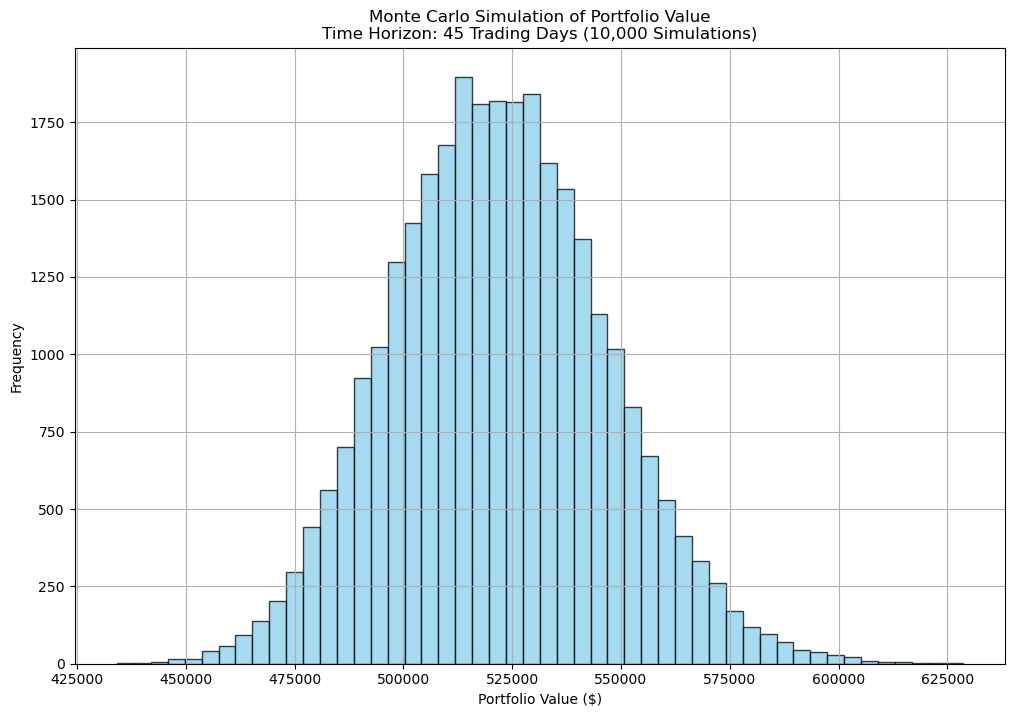

In [8]:
import math

# 1. Define the simulation time horizon.
# Simulation start and end dates (assumed as provided)
start_sim = "2025-02-16"
end_sim = "2025-04-18"

# Compute the number of business (trading) days between these dates.
business_days = pd.date_range(start_sim, end_sim, freq='B')
T = len(business_days)  # Number of trading days in the horizon
print("Time horizon (trading days):", T)

# 2. Merge the portfolio allocations with the risk/return parameters.
# We assume risk_return_df includes columns: "Symbol", "Annual Return", and "Volatility".
merged_df = pd.merge(allocations_df, 
                     risk_return_df[['Symbol', 'Annual Return', 'Volatility']], 
                     on="Symbol", how="left")

# 3. Convert annual parameters to daily parameters (assume 252 trading days per year).
merged_df['daily_mean'] = merged_df['Annual Return'] / 252.0
merged_df['daily_sigma'] = merged_df['Volatility'] / np.sqrt(252.0)

# 4. Set the number of Monte Carlo simulation iterations.
n_iter = 30000
portfolio_final_values = []

# 5. Run the simulation.
# For each iteration, simulate the final price for each asset using a Geometric Brownian Motion model.
for i in range(n_iter):
    total_value = 0
    for idx, row in merged_df.iterrows():
        # Starting price for the asset
        S0 = row['Price']
        mu = row['daily_mean']
        sigma = row['daily_sigma']
        # Draw one random sample from the standard normal distribution.
        Z = np.random.normal()
        # Compute the simulated price at the end of T days using GBM:
        # S_T = S0 * exp((mu - 0.5*sigma^2)*T + sigma*sqrt(T)*Z)
        S_T = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
        # Compute the asset value: number of shares * simulated final price.
        asset_value = row['Shares'] * S_T
        total_value += asset_value
    portfolio_final_values.append(total_value)

portfolio_final_values = np.array(portfolio_final_values)

# 6. Compute summary statistics for the simulated portfolio value.
mean_portfolio_value = portfolio_final_values.mean()
std_portfolio_value = portfolio_final_values.std()

print("\nSimulated Portfolio Value after", T, "trading days (30,000 simulations):")
print("Mean: ${:,.2f}".format(mean_portfolio_value))
print("Standard Deviation: ${:,.2f}".format(std_portfolio_value))

# 7. Plot a histogram of the simulated portfolio values.
plt.figure(figsize=(12, 8))
plt.hist(portfolio_final_values, bins=50, color="skyblue", edgecolor="black", alpha=0.75)
plt.xlabel("Portfolio Value ($)")
plt.ylabel("Frequency")
plt.title("Monte Carlo Simulation of Portfolio Value\nTime Horizon: {} Trading Days (10,000 Simulations)".format(T))
plt.grid(True)
plt.show()

In [16]:
mean_portfolio_change_dollar = portfolio_final_values.mean() - 500000
print("Mean portfolio change: ${:,.2f}".format(mean_portfolio_change_dollar))
mean_percentage_change_per = ((portfolio_final_values.mean() / 500000) - 1) * 100
print("Mean portfolio percentage change: {:.2f}%".format(mean_percentage_change_per))
risk_of_portfolio_per=std_portfolio_value/total_capital
print("Risk of portfolio: {:.5f}%".format(risk_of_portfolio_per*100))

Mean portfolio change: $21,868.64
Mean portfolio percentage change: 4.37%
Risk of portfolio: 4.94595%
